In [208]:
import pandas as pd
import numpy as np
import datetime
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
data0 = pd.read_csv("data/1019_SP.csv").dropna()
data1 = pd.read_csv("data/1019_CL.csv").dropna()
data2 = pd.read_csv("data/1019_OVX.csv").dropna()
data3 = pd.read_csv("data/1019_GC.csv").dropna()
data4 = pd.read_csv("data/1019_GVZ.csv").dropna()
Date = data0.get("Date")
Date = pd.to_datetime(Date)
Close = data0.get("Close")
Close_cl = data1.get("Close")
Close_ovx = data2.get("Close")
Close_gc = data3.get("Close")
Close_gvz = data4.get("Close")
dict = {"Date": Date,
        "close": Close, 
        "close_cl": Close_cl, 
        "close_ovx": Close_ovx,
        "close_gc": Close_gc, 
        "close_gvz": Close_gvz,
        "return":0,
       }
df = pd.DataFrame(dict)
df.set_index('Date', inplace=True)
df = df.dropna()
print("總共:%d個交易時間點" % (len(Date)))
print("去除空白值後剩下:%d個交易時間點" % (len(df)))
df.tail(10)

總共:2493個交易時間點
去除空白值後剩下:2493個交易時間點


,close,close_cl,close_ovx,close_gc,close_gvz,return
Date,,,,,,
2019-12-13,3168.800049,60.070000,26.760000,1475.599976,10.39,0
2019-12-16,3191.449951,60.209999,26.510000,1475.000000,10.39,0
2019-12-17,3192.520020,60.939999,26.330000,1474.599976,10.03,0
2019-12-18,3191.139893,60.930000,26.770000,1472.599976,10.04,0
2019-12-19,3205.370117,61.220001,24.799999,1478.199951,10.39,0
2019-12-20,3221.219971,60.439999,25.540001,1474.699951,9.69,0
2019-12-23,3224.010010,60.520000,25.110001,1482.500000,10.56,0
2019-12-26,3239.909912,61.680000,24.080000,1509.300049,13.33,0
2019-12-27,3240.020020,61.720001,25.160000,1513.800049,12.32,0


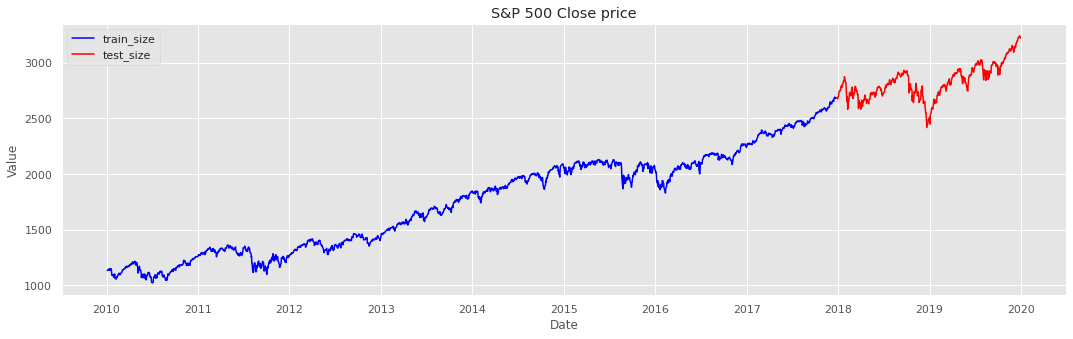

In [209]:
plt.style.use("ggplot")
train_size = int(len(df)*0.8)
plt.figure(figsize=(18, 5))
plt.plot((df['close'][:train_size]), color = 'blue', label='train_size')
plt.plot((df['close'][train_size:]), color = 'red', label='test_size')
plt.legend()
plt.title('S&P 500 Close price')
plt.ylabel('Value')
plt.xlabel('Date')
plt.show()

In [ ]:
dataset = pd.DataFrame({
    'Close':df['close'],
    'Close_CL':df['close_cl'],
    'Close_OVX':df['close_ovx'],
    'Close_GC':df['close_gc'],
    'Close_GVZ':df['close_gvz'],
    'return': df['close'].shift(-30) / df['close'],
})

feature_names = list(dataset.columns[:-1])

In [211]:
print("before dropping NaN", dataset.shape)
dataset = dataset.dropna()
print("after dropping NaN", dataset.shape)

before dropping NaN (2493, 6)
after dropping NaN (2463, 6)


In [212]:
from sklearn.preprocessing import MinMaxScaler

ss = MinMaxScaler()

dataset_scaled = ss.fit_transform(dataset)
dataset_scaled = pd.DataFrame(dataset_scaled, columns=dataset.columns, index=dataset.index)
dataset_scaled['return'] = dataset['return']
dataset_scaled.describe()

,Close,Close_CL,Close_OVX,Close_GC,Close_GVZ,return
count,2463.000000,2463.000000,2463.000000,2463.000000,2463.000000,2463.000000
mean,0.445973,0.529649,0.290710,0.351192,0.264141,1.013670
std,0.278454,0.250828,0.157299,0.214300,0.155674,0.040839
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.836084
25%,0.169877,0.296683,0.187839,0.206528,0.147409,0.992547
50%,0.461348,0.521888,0.269583,0.287504,0.249115,1.017755
75%,0.666880,0.769095,0.377850,0.442058,0.349694,1.040411
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.138779


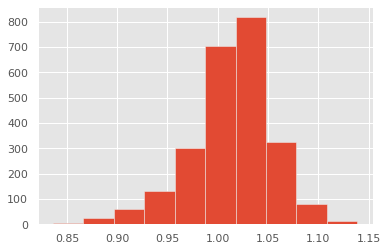

In [213]:
dataset_scaled['return'].hist()

In [214]:
from keras.utils import np_utils
time_period = 30

buy = 0
hold = 0
sell = 0

cnn_x = []
cnn_y = []
indexs = []
dataset_scaled_x= dataset_scaled[feature_names]

for i in tqdm.tqdm_notebook(range(0, len(dataset_scaled)-time_period-1-31)):
    cnn_x.append(dataset_scaled_x.iloc[i:i+time_period].values)
    r = dataset_scaled['return'].iloc[i+time_period-1]
    if r >=1.04:
        r = 2
        sell = sell+1
    elif r<=0.99:
        r = 0
        buy = buy+1
    else:
        r = 1
        hold = hold+1
    rr = np_utils.to_categorical(r, num_classes=3)
    cnn_y.append(rr)
    indexs.append(dataset_scaled.index[i+time_period-1])
    
cnn_x = np.array(cnn_x)
cnn_y = np.array(cnn_y)
indexes = np.array(indexs)
print("Buy: %.2f, Hold: %.2f, Sell: %.2f" % (buy,hold,sell))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  del sys.path[0]



Buy: 557.00, Hold: 1259.00, Sell: 585.00


In [ ]:
#2010~2018年為訓練和測試，2019年則為驗證
import datetime
cnn_x_t = cnn_x[indexes < datetime.datetime(2019,1,1)]
cnn_y_t = cnn_y[indexes < datetime.datetime(2019,1,1)]
cnn_x_validation = cnn_x[indexes > datetime.datetime(2019,1,1)]
cnn_y_validation = cnn_y[indexes > datetime.datetime(2019,1,1)]

In [ ]:
from sklearn.model_selection import train_test_split
cnn_x_train, cnn_x_test, cnn_y_train, cnn_y_test = train_test_split(cnn_x_t, cnn_y_t, 
                                                                    test_size=0.2,
                                                                    random_state =7,
                                                                    stratify=cnn_y_t,
                                                                    shuffle = True)

In [ ]:
cnn_x_train = np.stack((cnn_x_train,)*3,axis=-1)
cnn_x_test = np.stack((cnn_x_test,)*3,axis=-1)
cnn_x_validation = np.stack((cnn_x_validation,)*3,axis=-1)

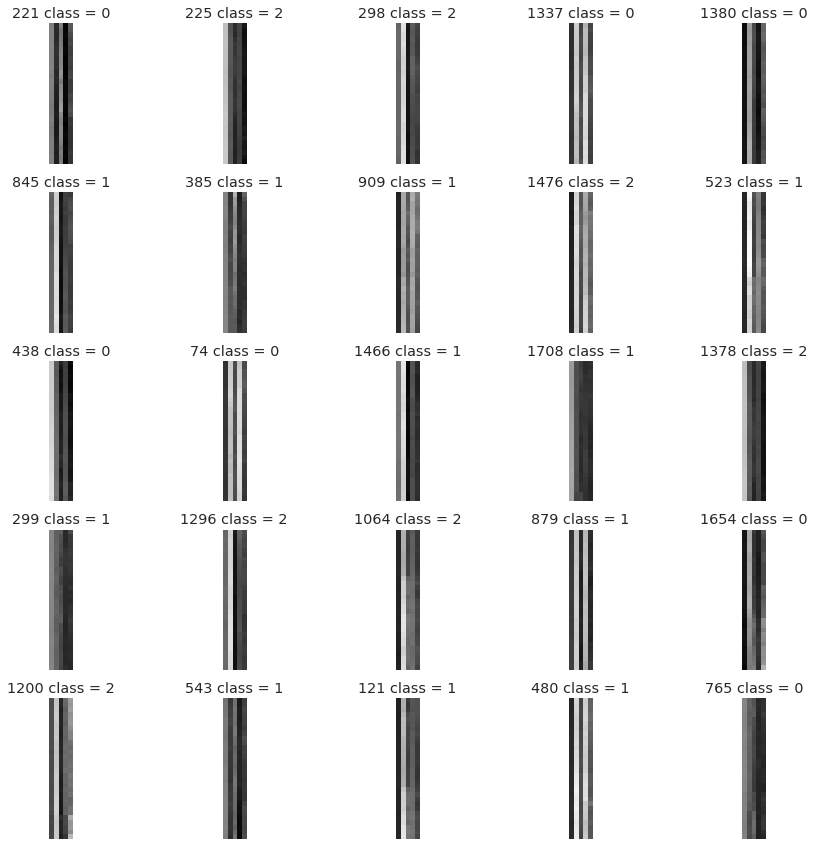

In [218]:
fig = plt.figure(figsize = (15,15))
columns = rows = 5
for i in range(1,columns*rows+1):
  index = np.random.randint(len(cnn_x_train))
  img = cnn_x_train[index]
  fig.add_subplot(rows,columns,i)
  plt.axis("off")
  plt.title(str(index)+' class = '+str(np.argmax(cnn_y_train[index])))
  plt.subplots_adjust(wspace=0.2,hspace=0.2)
  plt.imshow(img)
plt.show()

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
#import tensorflow.keras import backend as K
#import tensorflow.keras.utils import get_custom_objects
def get_sample_weights(y):
  y = y.astype(int)
  class_weight = compute_class_weight('balanced',np.unique(y),y)
  print("real class weight are{}".format(class_weight),np.unique(y))
  print("value_counts",np.unique(y,return_counts=True))
  sample_weights = y.copy().astype(float)
  for i in np.unique(y):
    sample_weights[sample_weights==i]=class_weight[i]
  return class_weight,sample_weights

In [228]:
#將onehot編碼轉回數組
#lable = np.argmax(cnn_y_train, axis=1)
lable = np.argmax(cnn_y_validation, axis=1)
lable = np.array(lable)
class_weight,sample_weights = get_sample_weights(lable)

real class weight are[1.46825397 0.7254902  1.06321839] [0 1 2]
value_counts (array([0, 1, 2]), array([42, 85, 58]))


In [229]:
class_weight={0:class_weight[0],
              1:class_weight[1],
              2:class_weight[2],}
print(class_weight)

{0: 1.4682539682539681, 1: 0.7254901960784313, 2: 1.0632183908045978}


In [ ]:
import tensorflow.keras
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import he_normal

input_shape = cnn_x_train[0].shape

def get_model(dropout1_rate=0.5, dropout2_rate=0.5):
    model = Sequential()
    model.add(layers.Conv2D(filters=32, 
                            kernel_size=(3,3), 
                            activation='relu',
                            padding="same",
                            input_shape=input_shape))
    model.add(layers.Conv2D(filters=64, 
                            kernel_size=(3,3), 
                            padding="same", 
                            activation='relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(dropout1_rate, name="dropout_1"))
    model.add(layers.Flatten())
    model.add(layers.Dense(units=128, activation='relu'))
    model.add(layers.Dropout(dropout2_rate, name="dropout_2"))
    model.add(layers.Dense(units=3, activation='softmax'))
    return model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping 
earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

def fit_with(dropout1_rate, dropout2_rate, lr, batchsize):

    # batchsize只能是整數，強迫把浮點轉int
    batchsize = int(batchsize)

    # 使用指定的超參數創建模型。
    model = get_model(dropout1_rate, dropout2_rate)
    
    # 設定優化器、學習率並建模
    optimizer = tensorflow.keras.optimizers.Adam(lr=lr)
    model.compile(loss='categorical_crossentropy',optimizer=optimizer, metrics=['accuracy'])
    
    # 使用訓練數據集訓練模型。
    model.fit(cnn_x_train, cnn_y_train,
              batch_size = batchsize,
              epochs=250,
              verbose=0,
              validation_data=(cnn_x_test,cnn_y_test),
              callbacks=[earlystop],
              class_weight=class_weight,
              )
    # steps=10 = 評估階段結束之前的步驟總數（樣本批次）
    # score = model.evaluate(cnn_x_test,cnn_y_test, steps=10, verbose=0)
    # 使用測試數據集評估模型。
    score = model.evaluate(cnn_x_test, cnn_y_test, verbose=0)
    #print('Test loss:', score[0])
    #print('Test accuracy:', score[1])

    return score[1]

In [143]:
from bayes_opt import BayesianOptimization

optimizer = BayesianOptimization(
        fit_with,
        {'dropout1_rate': (0, 0.5),
        'dropout2_rate': (0, 0.5),
        'lr': (1e-5, 1e-2),
        'batchsize': (16,128)}
    )
optimizer.maximize(init_points=10, n_iter=20)

|   iter    |  target   | batchsize | dropou... | dropou... |    lr     |
-------------------------------------------------------------------------
Epoch 00030: early stopping
|  1        |  0.6239   |  88.65    |  0.3946   |  0.03837  |  0.009047 |
Epoch 00102: early stopping
|  2        |  0.6802   |  36.33    |  0.4377   |  0.1464   |  0.007182 |


KeyboardInterrupt: ignored

In [112]:
print(optimizer.max)
print(optimizer.max['params']['dropout1_rate'])
print(optimizer.max['params']['dropout2_rate'])
print(optimizer.max['params']['lr'])
print(optimizer.max['params']['batchsize'])
##Bayesian Optimization 找到的最佳超參數值
dropout_rate1 = optimizer.max['params']['dropout1_rate']
dropout_rate2 = optimizer.max['params']['dropout2_rate']
learning_rate = optimizer.max['params']['lr']
batchsize = int(optimizer.max['params']['batchsize'])

{}


KeyError: ignored

In [ ]:
dropout_rate1 = 0.4607
dropout_rate2 = 0.06143
learning_rate = 0.006671
batchsize = int(94.21)

In [232]:
import tensorflow.keras
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import he_normal

input_shape = cnn_x_train[0].shape

model = Sequential()
model.add(layers.Conv2D(filters=32, 
                        kernel_size=(3,3), 
                        activation='relu',
                        padding="same",
                        input_shape=input_shape))
model.add(layers.Conv2D(filters=64, 
                        kernel_size=(3,3), 
                        padding="same", 
                        activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Dropout(dropout_rate1, name="dropout_1"))
model.add(layers.Flatten())
model.add(layers.Dense(units=128, activation='relu'))
model.add(layers.Dropout(dropout_rate2, name="dropout_2"))
model.add(layers.Dense(units=3, activation='softmax'))

adam = tensorflow.keras.optimizers.Adam(learning_rate)

model.compile(loss='categorical_crossentropy',optimizer=adam, metrics=['accuracy'])
print(model.summary())

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 30, 5, 32)         896       
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 30, 5, 64)         18496     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 15, 2, 64)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 2, 64)         0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 1920)              0         
_________________________________________________________________
dense_44 (Dense)             (None, 128)               245888    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)             

In [233]:
history = model.fit(cnn_x_train, cnn_y_train,
                    batch_size=batchsize,
                    epochs=250,
                    verbose=1,
                    validation_data=(cnn_x_test,cnn_y_test),
                    callbacks=[earlystop],
                    #sample_weight=sample_weights,
                    class_weight=class_weight,
                    )

Epoch 1/250
19/19 [==============================] - 1s 65ms/step - loss: 1.1118 - accuracy: 0.3674 - val_loss: 1.0288 - val_accuracy: 0.5293
Epoch 2/250
19/19 [==============================] - 1s 61ms/step - loss: 1.0459 - accuracy: 0.4599 - val_loss: 1.0509 - val_accuracy: 0.5293
Epoch 3/250
19/19 [==============================] - 1s 60ms/step - loss: 1.0465 - accuracy: 0.5147 - val_loss: 1.0388 - val_accuracy: 0.4955
Epoch 4/250
19/19 [==============================] - 1s 62ms/step - loss: 1.0384 - accuracy: 0.4362 - val_loss: 1.0287 - val_accuracy: 0.5450
Epoch 5/250
19/19 [==============================] - 1s 60ms/step - loss: 1.0345 - accuracy: 0.4870 - val_loss: 1.0466 - val_accuracy: 0.5991
Epoch 6/250
19/19 [==============================] - 1s 61ms/step - loss: 1.0287 - accuracy: 0.4960 - val_loss: 0.9952 - val_accuracy: 0.5405
Epoch 7/250
19/19 [==============================] - 1s 60ms/step - loss: 1.0083 - accuracy: 0.5339 - val_loss: 0.9496 - val_accuracy: 0.5676
Epoch 

In [234]:
o_loss,o_accuracy = model.evaluate(cnn_x_train,cnn_y_train)
print("對訓練資料的：\nLoss: %.2f, Accuracy: %.2f" % (o_loss, o_accuracy))
n_loss,n_accuracy = model.evaluate(cnn_x_test,cnn_y_test)
print("對測試資料的：\nLoss: %.2f, Accuracy: %.2f" % (n_loss, n_accuracy))

56/56 [==============================] - 0s 7ms/step - loss: 0.4433 - accuracy: 0.8064
對訓練資料的：
Loss: 0.44, Accuracy: 0.81
14/14 [==============================] - 0s 7ms/step - loss: 0.5383 - accuracy: 0.7500
對測試資料的：
Loss: 0.54, Accuracy: 0.75


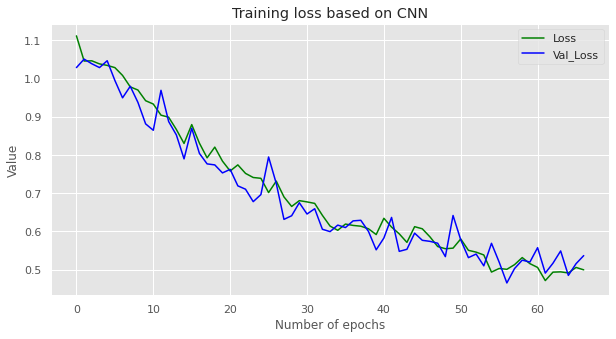

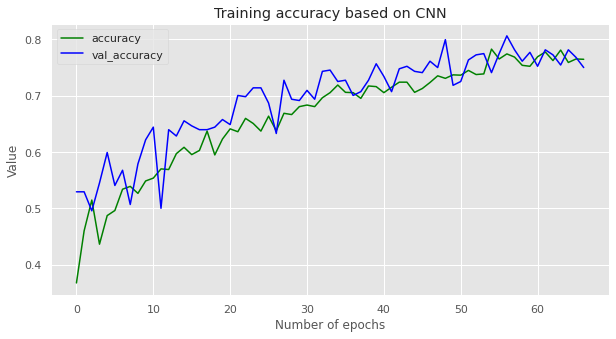

In [235]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], color = 'green', label='Loss')
plt.plot(history.history['val_loss'], color = 'blue', label='Val_Loss')
plt.legend()
plt.title('Training loss based on CNN')
plt.ylabel('Value')
plt.xlabel('Number of epochs')
plt.show()
plt.style.use("ggplot")
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], color = 'green', label='accuracy')
plt.plot(history.history['val_accuracy'], color = 'blue', label='val_accuracy')
plt.legend()
plt.title('Training accuracy based on CNN')
plt.ylabel('Value')
plt.xlabel('Number of epochs')
plt.show()

In [ ]:
#將onehot編碼轉回數組
cnn_y_test = np.argmax(cnn_y_test, axis=1)
xcnn_y_test = pd.Series(cnn_y_test)
#預測測試集
pre = model.predict_classes(cnn_x_test)
pre = pd.Series(pre)

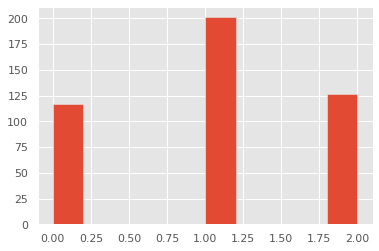

In [237]:
pre.hist()

對訓練集資料的：Loss: 0.44, Accuracy: 0.81
對測試集資料的：Loss: 0.54, Accuracy: 0.75

測試資料總共：444.00 筆
其中 Buy 的筆數為: 106.00, 全部猜 Buy 猜對的機率是: 0.24
其中 Hold 的筆數為: 235.00, 全部猜 Hold 猜對的機率是: 0.53
其中 Sell 的筆數為: 103.00, 全部猜 Sell 猜對的機率是: 0.23

該測試集資料的 Accuracy 為: 0.75 
Precision(Buy): 0.74, Recall(Buy): 0.83, F1 score(Buy): 0.78
Precision(Hold): 0.82, Recall(Hold): 0.70, F1 score(Hold): 0.75
Precision(Sell): 0.66, Recall(Sell): 0.78, F1 score(Sell): 0.72


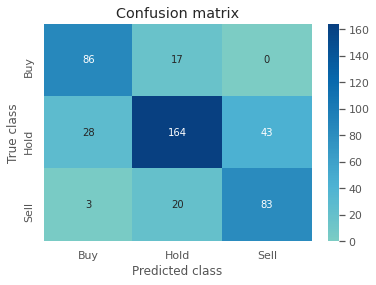

In [238]:
from sklearn.metrics import confusion_matrix

LABELS = ["Buy","Hold","Sell"]
conf_matrix = confusion_matrix(xcnn_y_test, pre)
#原始資料
t_size = len(cnn_y_test)
b_size = (cnn_y_test>=2).sum()
s_size = (cnn_y_test<=0).sum()
h_size = t_size-(b_size+s_size)
b_guess = b_size/t_size
s_guess = s_size/t_size
h_guess = h_size/t_size
#矩陣數字
c00 = conf_matrix[0][0]
c01 = conf_matrix[0][1]
c02 = conf_matrix[0][2]
c10 = conf_matrix[1][0]
c11 = conf_matrix[1][1]
c12 = conf_matrix[1][2]
c20 = conf_matrix[2][0]
c21 = conf_matrix[2][1]
c22 = conf_matrix[2][2]
#評估指標
accuracy = (c00+c11+c22)/t_size
precision_b = c00/(c00+c10+c20)
precision_h = c11/(c01+c11+c21)
precision_s = c22/(c02+c12+c22)
recall_b = c00/(c00+c01+c02)
recall_h = c11/(c10+c11+c12)
recall_s = c22/(c20+c21+c22)
F1_b = 2*((precision_b*recall_b)/(precision_b+recall_b))
F1_h = 2*((precision_h*recall_h)/(precision_h+recall_h))
F1_s = 2*((precision_s*recall_s)/(precision_s+recall_s))
#印出
print("對訓練集資料的：Loss: %.2f, Accuracy: %.2f" % (o_loss, o_accuracy))
print("對測試集資料的：Loss: %.2f, Accuracy: %.2f" % (n_loss, n_accuracy))
print("\n測試資料總共：%.2f 筆\n其中 Buy 的筆數為: %.2f, 全部猜 Buy 猜對的機率是: %.2f" % (t_size, b_size, b_guess))
print("其中 Hold 的筆數為: %.2f, 全部猜 Hold 猜對的機率是: %.2f" % (h_size, h_guess))
print("其中 Sell 的筆數為: %.2f, 全部猜 Sell 猜對的機率是: %.2f" % (s_size, s_guess))
print("\n該測試集資料的 Accuracy 為: %.2f \nPrecision(Buy): %.2f, Recall(Buy): %.2f, F1 score(Buy): %.2f" % (accuracy, precision_b, recall_b, F1_b))
print("Precision(Hold): %.2f, Recall(Hold): %.2f, F1 score(Hold): %.2f" % (precision_h, recall_h, F1_h))
print("Precision(Sell): %.2f, Recall(Sell): %.2f, F1 score(Sell): %.2f" % (precision_s, recall_s, F1_s))
#畫圖
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",center=0.7,cmap = 'GnBu');
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

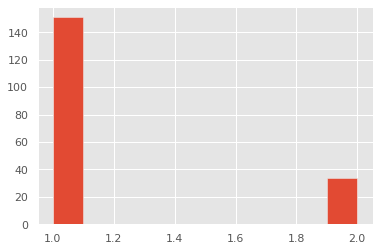

In [239]:
#將onehot編碼轉回數組cnn_x_validation
cnn_y_validation = np.argmax(cnn_y_validation, axis=1)
xcnn_y_validation = pd.Series(cnn_y_validation)
#預測
pre = model.predict_classes(cnn_x_validation)
pre = pd.Series(pre)
pre.hist()

對訓練集資料的：Loss: 0.44, Accuracy: 0.81
對測試集資料的：Loss: 0.54, Accuracy: 0.75

驗證資料總共：185.00 筆
其中 Buy 的筆數為: 58.00, 全部猜 Buy 猜對的機率是: 0.31
其中 Hold 的筆數為: 85.00, 全部猜 Hold 猜對的機率是: 0.46
其中 Sell 的筆數為: 42.00, 全部猜 Sell 猜對的機率是: 0.23

該測試集資料的 Accuracy 為: 0.55 
Precision(Buy): nan, Recall(Buy): 0.00, F1 score(Buy): nan
Precision(Hold): 0.54, Recall(Hold): 0.96, F1 score(Hold): 0.69
Precision(Sell): 0.59, Recall(Sell): 0.34, F1 score(Sell): 0.43


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in long_scalars


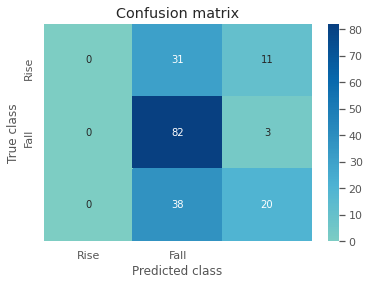

In [240]:
from sklearn.metrics import confusion_matrix

LABELS = ["Buy","Hold","Sell"]
conf_matrix = confusion_matrix(xcnn_y_validation, pre)

#原始資料
t_size = len(cnn_y_validation)
b_size = (cnn_y_validation>=2).sum()
s_size = (cnn_y_validation<=0).sum()
h_size = t_size-(b_size+s_size)
b_guess = b_size/t_size
s_guess = s_size/t_size
h_guess = h_size/t_size
#矩陣數字
c00 = conf_matrix[0][0]
c01 = conf_matrix[0][1]
c02 = conf_matrix[0][2]
c10 = conf_matrix[1][0]
c11 = conf_matrix[1][1]
c12 = conf_matrix[1][2]
c20 = conf_matrix[2][0]
c21 = conf_matrix[2][1]
c22 = conf_matrix[2][2]
#評估指標
accuracy = (c00+c11+c22)/t_size
precision_b = c00/(c00+c10+c20)
precision_h = c11/(c01+c11+c21)
precision_s = c22/(c02+c12+c22)
recall_b = c00/(c00+c01+c02)
recall_h = c11/(c10+c11+c12)
recall_s = c22/(c20+c21+c22)
F1_b = 2*((precision_b*recall_b)/(precision_b+recall_b))
F1_h = 2*((precision_h*recall_h)/(precision_h+recall_h))
F1_s = 2*((precision_s*recall_s)/(precision_s+recall_s))
#印出
print("對訓練集資料的：Loss: %.2f, Accuracy: %.2f" % (o_loss, o_accuracy))
print("對測試集資料的：Loss: %.2f, Accuracy: %.2f" % (n_loss, n_accuracy))
print("\n驗證資料總共：%.2f 筆\n其中 Buy 的筆數為: %.2f, 全部猜 Buy 猜對的機率是: %.2f" % (t_size, b_size, b_guess))
print("其中 Hold 的筆數為: %.2f, 全部猜 Hold 猜對的機率是: %.2f" % (h_size, h_guess))
print("其中 Sell 的筆數為: %.2f, 全部猜 Sell 猜對的機率是: %.2f" % (s_size, s_guess))
print("\n該測試集資料的 Accuracy 為: %.2f \nPrecision(Buy): %.2f, Recall(Buy): %.2f, F1 score(Buy): %.2f" % (accuracy, precision_b, recall_b, F1_b))
print("Precision(Hold): %.2f, Recall(Hold): %.2f, F1 score(Hold): %.2f" % (precision_h, recall_h, F1_h))
print("Precision(Sell): %.2f, Recall(Sell): %.2f, F1 score(Sell): %.2f" % (precision_s, recall_s, F1_s))
#畫圖
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d",center=0.7,cmap = 'GnBu');
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()